In [5]:
import os
os.environ['PATH_SOURCE_DATA'] = '/workspace/projects/boostdm/nature-release/source-data'

%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import sys
from itertools import compress
import matplotlib.colors as clr
from math import pi


sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

import warnings
warnings.filterwarnings('ignore')

from fetch_data_needle import create_observed_dataset, get_mutations, get_plot_data
from plot_needle import plot_observed_distribution

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)


from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.decomposition import PCA
cmap = cm.RdYlGn_r

from clustering import generate_hierarchy, draw_flat_cluster
from retrieve import get_shaps

# Figure 2a

In [2]:
obs_muts = get_mutations()

def needleplot(gene, ttype, plotname=None):
    df = create_observed_dataset(gene, ttype, obs_muts)
    args = get_plot_data(df)
    plot_observed_distribution(gene, ttype, *args, plotname=plotname)

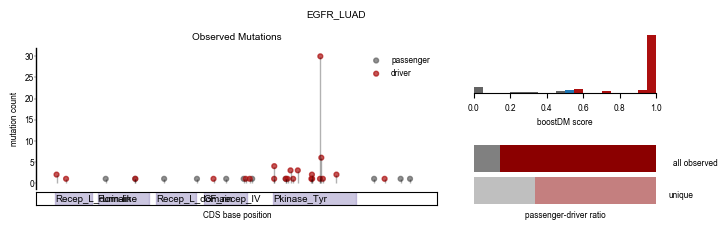

In [3]:
gene, ttype = 'EGFR', 'LUAD'
needleplot(gene, ttype, plotname=f'./raw_plots/{gene}.{ttype}')

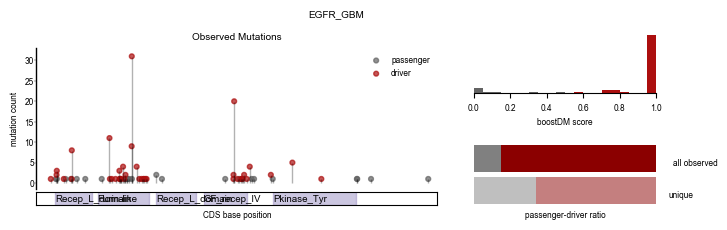

In [4]:
gene, ttype = 'EGFR', 'GBM'
needleplot(gene, ttype, plotname=f'./raw_plots/{gene}.{ttype}')

# Figure 2b

In [5]:
if not(os.path.exists(f"source_data/observed_mutations_with_shapleys_EGFR_LUAD.tsv")) or not(os.path.exists(f"source_data/observed_mutations_with_shapleys_EGFR_GBM.tsv")):
    !python scripts/prepare_tables_all_mutations.py 

In [6]:
def plot_radar_mutation(features,values,drivers,path_output):
    # Definition of variables 
    fig = plt.subplots(figsize=(1.,1.))
    categories=features
    degron = "_GLOBAL_VALUE"

    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.vlines(angles[:-1], 0, [3 for x in range(len(angles[:-1]))], colors="#DCDCDC", zorder=3,linewidth=0.5,alpha=0.5) 
    # Draw ylabels
    ax.set_rlabel_position(0)
    maxv = int(np.amax(values))+1
    minv = int(np.amin(values))-1
    plt.ylim(minv,maxv)
    plt.yticks(np.arange(minv,maxv+1,1), np.arange(minv,maxv+1,1), color="black", size=5)
    values +=  values[:1]
    #ax.plot(angles, values, linewidth=1.15, linestyle='solid', label="Drivers",color="#a64040ff")
    
    # Drivers
    values_true = list(compress(list(values),list(drivers)))
    # plot each value
    for case in values_true:
        case = list(case)
        case += case[:1]
        ax.plot(angles, case, linewidth=0.25, linestyle='solid', label="Drivers",color="#a64040ff")
    
    ax.grid(b=None,axis="x")
    ax.grid(axis="y",lw=0.25)
    
    # Draw one axe per variable + add labels labels yet
    print (name)
    _=plt.xticks(angles[:-1], [conf.name_features[x]  for x in features],fontsize=4)
    plt.savefig(path_output,dpi=800,bbox_inches="tight")
    plt.show()
    


### Plot them

raw_plots/all_drivers_EGFR__LUAD.svg


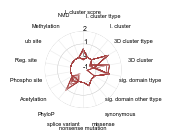

raw_plots/all_drivers_EGFR__GBM.svg


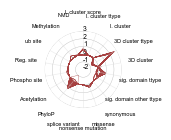

In [5]:
gene = "EGFR"
for ttype in ["LUAD","GBM"]:
    df_data = pd.read_csv(f"source_data/observed_mutations_with_shapleys_EGFR_{ttype}.tsv",sep="\t")
    drivers = df_data[(df_data["boostDM_class"])]
    values = list(drivers[conf.features].values)
    drivers = list(drivers["boostDM_class"].values)
    name = os.path.join("raw_plots","all_drivers"+"_"+gene+"_"+"_"+ttype+".svg")
    plot_radar_mutation(conf.features,values,drivers,name)

### function to plot per color

In [20]:
def to_hex(a,b,c):
    return '#%02x%02x%02x' % (int(a*255), int(b*255), int(c*255))
def create_scale(maxv,minv):
    maxv = np.nanmax(maxv) 
    minv = np.nanmin(minv)
    norm = clr.Normalize(vmin=minv,vmax=maxv)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=norm)
    return sm
def get_colors(row,scales):
    colors = []
    for i in range(0,len(row)):
        sm = scales[i]
        colors.append(to_hex(*sm.to_rgba(row[i])[0:3]))
    return colors

### Function to plot radar for a single mutation

In [21]:
def plot_radar_single_mutation(features,values,drivers,path_output):
    # Definition of variables 
    fig = plt.subplots(figsize=(1.,1.))
    categories=features
    degron = "_GLOBAL_VALUE"

    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.vlines(angles[:-1], 0, [3 for x in range(len(angles[:-1]))], colors="#DCDCDC", zorder=3,linewidth=0.5,alpha=0.5) 
    # Draw ylabels
    ax.set_rlabel_position(0)
    maxv = int(np.amax(values))+1
    minv = int(np.amin(values))-1
    plt.ylim(minv,maxv)
    plt.yticks(np.arange(minv,maxv+1,1), np.arange(minv,maxv+1,1), color="black", size=5)
    values +=  values[:1]
    ax.plot(angles, values, linewidth=1.15, linestyle='solid', label="Drivers",color="#a64040ff")
    ax.grid(b=None,axis="x")
    ax.grid(axis="y",lw=0.25)
    
    # Draw one axe per variable + add labels labels yet
    _=plt.xticks(angles[:-1], [conf.name_features[x]  for x in features],fontsize=4)
    plt.savefig(path_output,dpi=800,bbox_inches="tight")
    


In [22]:
path_saturation=os.path.join(conf.output_boostdm,"saturation","prediction")

# Figure 2c 

In [23]:
examples = [("RB1","E51*","BLCA"),("VHL","S80R","RCCC"),("CIC","R202W","LGG"),("TP53","K132R","LUSC")]

In [24]:
for gene,mut,ttype in examples:
    path_file = os.path.join(path_saturation,f"{gene}.{ttype}.prediction.tsv.gz")
    df_data = pd.read_csv(path_file,sep="\t")
    df_data[(df_data["boostDM_class"])&(df_data["gene"]==gene)&(df_data["aachange"]==mut)].to_csv(f"source_data/{gene}_{ttype}_{mut}_radar_source.tsv",sep="\t")
    muts = df_data[(df_data["boostDM_class"])&(df_data["gene"]==gene)&(df_data["aachange"]==mut)]["aachange"].unique()
    for mut in muts:
        df = df_data[df_data["aachange"]==mut].drop_duplicates()
        for i,r in df.iterrows():
            selected_model = r["selected_model_ttype"]
            selected_model_gene = r["selected_model_gene"]
            gene = r["gene"]
            values = [r.loc[feature] for feature in conf.features]
            drivers = [r["boostDM_class"]]
            name = os.path.join("raw_plots",gene+"_"+mut+"_"+ttype+".svg")
            plot_radar_single_mutation(conf.features,values,drivers,name)

# Figure 2d 

In [2]:
df_stats = pd.read_csv(conf.cohorts_path, sep="\t")

# mapping MoA colors to each (gene, ttype)

dg = pd.read_csv(conf.drivers_path, sep='\t')
d = dict(zip(zip(dg.SYMBOL, dg.CANCER_TYPE), map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))
d_gene = dict(zip(dg.SYMBOL, map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))

# load observed mutations

mutations = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'mutations.tsv'), sep='\t')

df = get_shaps(mutations, None, None)

100%|██████████| 249/249 [02:08<00:00,  1.95it/s]


In [3]:
def low_rank(gene, ttype):
    
    df = get_shaps(mutations, None, None)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    df = df[conf.features]
    pca = PCA(10, whiten=True)
    projected = pca.fit_transform(df)
    return df, projected, moa_colors, complexity_colors


def cluster_heatmap(gene, ttype, mode='flat', labels=None, title=None, fn=None):
    
    df, projected, moa_colors, complexity_colors = low_rank(gene, ttype)
    X, linkage, scores, classes, labels_list = generate_hierarchy(df)
    if mode == 'flat':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', mode=mode, title=title, fn=fn)
    elif mode == 'moa':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', moa_colors=moa_colors,
                          mode=mode, title=title, fn=fn)
    return labels_list[2]

100%|██████████| 249/249 [02:28<00:00,  1.68it/s]


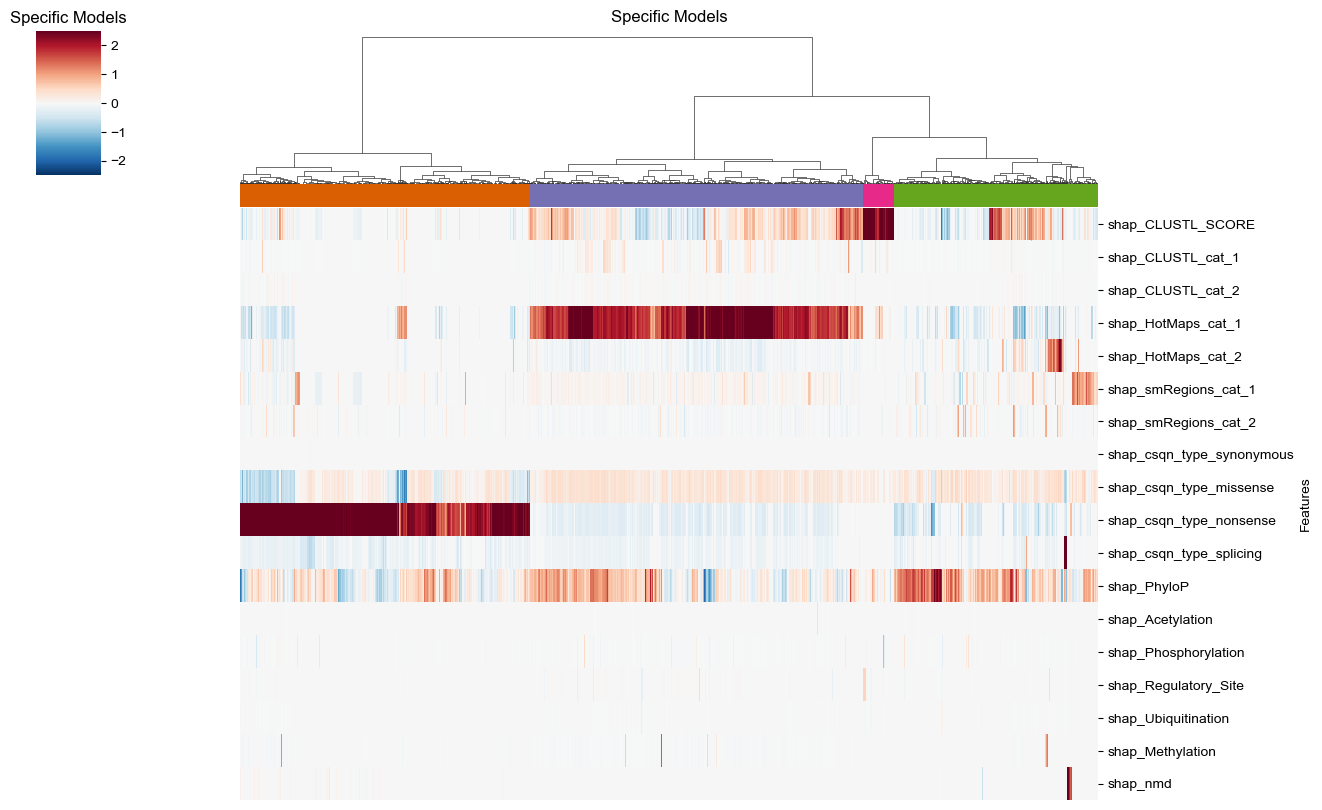

In [7]:
# unique observed mutations 
# per gene-ttype
# covered by specific models 
# with boostDM positive

labels_hierarchical = cluster_heatmap(None, None, mode='flat', 
                                      title='Specific Models', 
                                      fn='observed.specific.driver.hierarchy')

100%|██████████| 249/249 [02:39<00:00,  1.56it/s]


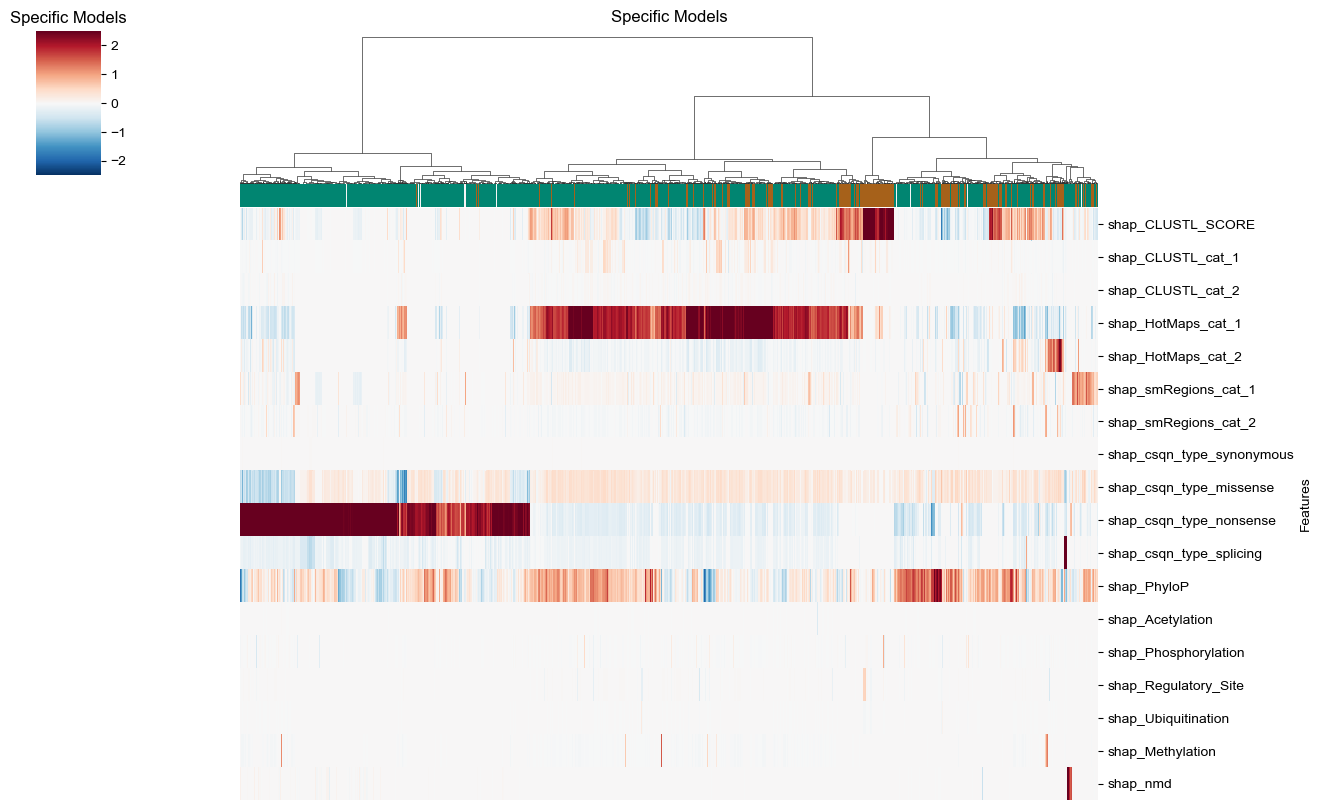

In [8]:
l = cluster_heatmap(None, None, mode='moa', title='Specific Models', fn='observed.specific.driver.moa')